<center> 
    <h1> 
        Data Camp Project

 <center>
    <h1> 
        Prediction of the engagement rate on Instagram

# Table of content
1. [Introduction](#Introduction)
    - [Growing influence of Instagram](#See_later)
    - [Definition of the problem : Quantify the reaction to a post](#See_later)
2. [Data exploration](#Data_exploration)
    - [Data Processing](#Data_Processing)
    - [Top 50 : What are the kind of people in it ?](#See_later)
    - [Impact of the day of the week ?](#See_later)
    - [Correlation between the numbers of comments and likes](#See_later)
3. [Workflow](#Workflow)
4. [Submission](#Submission)

# Import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import re

# Introduction

## Growing influence of Instagram

The leading treads towards social networking services had drawn massive
public attention from last one and half decade. The amount of data that is
uploaded to these social networking services is increasing day by day. So,
there is massive requirement to study the highly dynamic behavior of users
towards these services. Let's now focus of one the most used social networks : Instagram 

Instagram is an American photo and video sharing social networking service. In 2018, Instagram has reached 1 billion monthly active users. 

## Interest for Brands

Brands are currently aware of the growing influence of Instagram described above. As a result, they might see an interest to show up in Instragram. Because, this platforn is potentially a great canal of promotion. But to be efficient, a brand has to choose cleverly how it shows up in Instagram. And it why machine learning appeared as potentially relevant. Indeed, by collecting data on Instagram, a brand can find what kind of posts creates a lot of reactions.

Before going deeper in the analysis, it is important to clearly define a metric to quantify the term "reaction". The engagment is for instance a concept relevant in order to quantify the reactions to a post.

## Definition of the problem : Quantify the reaction to a post

Aim : Predict the engagment rate by instagramers

Scoring : "Root mean square error" which is defined by the following formula : 

    

# Data exploration

In [3]:
df1 = pd.read_csv('Data/2.Final_dataset/posts_infos_influencers_world_0_10.csv')
df2 = pd.read_csv('Data/2.Final_dataset/posts_infos_influencers_world_10_20.csv')
df3 = pd.read_csv('Data/2.Final_dataset/posts_infos_influencers_world_20_30.csv')
df4 = pd.read_csv('Data/2.Final_dataset/posts_infos_influencers_world_30_40.csv')

df_1 = pd.concat([df1, df2], axis=0)
df_2 = pd.concat([df3, df4], axis=0)

df = pd.concat([df_1, df_2], axis=0)
df = df.drop(columns = ['Links to publication', 'Links to profile', 'Account description',
                       'Verified Status'])
print(df.shape)
df.head(3)

(21899, 10)


,Name Account/Influencer,Professional Activity,Number of posts,Number of followers,Number of followings,Post description,Post number of comments,Post number of likes,Posting date,Media Type
0,Cristiano Ronaldo,Footballeur,2 982 publications,253 140 888,459,Another week of playing inside and staying act...,22995,15 023 301,2020-04-11T09:02:26.000Z,Video
1,Cristiano Ronaldo,Footballeur,2 982 publications,253 140 888,459,We wish a Happy Easter to everyone 🌍❤️🙏\n#stay...,62374,9 661 590,2020-04-12T13:18:16.000Z,Photo
2,Cristiano Ronaldo,Footballeur,2 982 publications,253 140 888,459,".\n\nKids, let the Dad do his work 🤷🏻‍♂️❤️😝 #s...",108402,43 462 083,2020-04-13T12:57:43.000Z,Video


In [4]:
df['Post number of likes'] = df['Post number of likes'].apply(lambda x : x.replace(",",""))
df['Post number of likes'] = df['Post number of likes'].apply(lambda x : x.replace(" ","")).astype(int)
df['Post number of comments'] = df['Post number of comments'].astype(int)
                                                              
df['Number of followers'] = df['Number of followers'].apply(lambda x : x.replace(",",""))
df['Number of followers'] = df['Number of followers'].apply(lambda x : x.replace(" ","")).astype(int)      

df['Number of posts'] = df['Number of posts'].apply(lambda x : x.replace("publications",""))
df['Number of posts'] = df['Number of posts'].apply(lambda x : x.replace("posts",""))
df['Number of posts'] = df['Number of posts'].apply(lambda x : x.replace(",",""))
df['Number of posts'] = df['Number of posts'].apply(lambda x : x.replace(" ","")).astype(int)

#Count the number of words in the description
df['Number of words'] = pd.Series([len(re.findall(r'\w+', line)) for line in df['Post description']])

In [5]:
df.dtypes

Name Account/Influencer    object
Professional Activity      object
Number of posts             int64
Number of followers         int64
Number of followings       object
Post description           object
Post number of comments     int64
Post number of likes        int64
Posting date               object
Media Type                 object
Number of words             int64
dtype: object

## Top 50 : What are the kind of people in it ?

Before going deeper in the analysis of the dataset, it seems relevant to clearly understand and visualize who are the instagramers inside these top 50. Therefore, we are going to perform a clustering algorithm in order to identify the different kind of instagramers.

In [134]:
df_clst = df.drop(columns = ['Post description', 'Posting date', 'Number of words', 
                            'Number of followings'])

df_clst['Media Type'] = df_clst['Media Type'].replace({'Video':0, 'Photo':1})

In [135]:
df_clst['Professional Activity'] = df_clst['Professional Activity'].apply(lambda x : x.lower())
df_clst['Professional Activity'] = df_clst['Professional Activity'].apply(lambda x : x.replace(' et ',''))
df_clst['Professional Activity'] = df_clst['Professional Activity'].apply(lambda x : x.replace('cienne','cien'))
df_clst['Professional Activity'] = df_clst['Professional Activity'].apply(lambda x : x.replace('trice','teur'))
df_clst['Professional Activity'] = df_clst['Professional Activity'].apply(lambda x : x.replace('comédienne',
                                                                                               'acteur'))
df_clst['Professional Activity'] = df_clst['Professional Activity'].replace({'footballeur':'Sportif',
                                        'joueur de basket-ball':'Sportif','acteur':'Acteur/Actrice',
                                        'acteurcatcheur professionnel':'Acteur/Actrice','magazine':'Marque',
                                        'vêtements':'Marque','musicienacteur':'Musicien/Musicienne',
                                        'club de football':'Marque', 'joueur de cricket':'Sportif',
                                        'ex-footballeur':'Sportif','agence spatiale':'Marque',
                                        'compétition de football':'Marque','acteurmusicien':'Acteur/Actrice',
                                        'lingerie':'Marque','modèle':'Modèle','musicien':'Musicien/Musicienne',
                                         'personnalité de téléréalitémodèle': 'Personnalité de téléréalité',
                                         'personnalité de téléréalité':'Personnalité de téléréalité'})

The distribution of the different kind of activities among the top 40 world's instagramers is shown below :

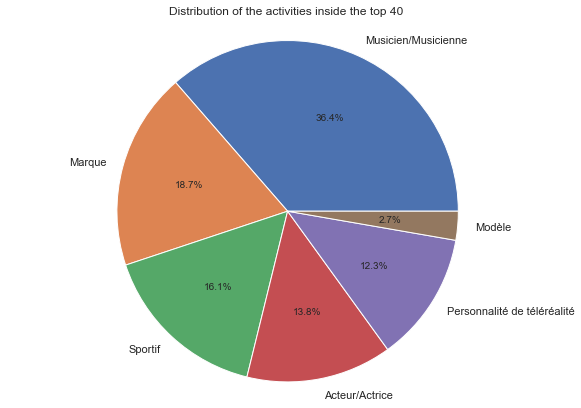

In [142]:
activity = df_clst['Professional Activity'].value_counts() / df_clst.shape[0]

plt.figure(figsize=(10,7))
plt.pie(activity,
        labels=activity.index,
        autopct='%1.1f%%')
plt.title("Distribution of the activities inside the top 40")
plt.axis('equal')
plt.show()

In [143]:
df_clst = pd.concat([df_clst, pd.get_dummies(df_clst['Professional Activity'],drop_first=True)],axis=1)
df_clst = df_clst.drop(columns = ['Professional Activity'])

instagramers = df_clst.groupby(['Name Account/Influencer']).mean()
instagramers = instagramers.rename(columns = {'Media Type':'Prop. of photo'})
instagramers.head(3)

,Number of posts,Number of followers,Post number of comments,Post number of likes,Prop. of photo,Marque,Modèle,Musicien/Musicienne,Personnalité de téléréalité,Sportif
Name Account/Influencer,,,,,,,,,,
Ariana Grande,4748.0,215459527.0,22226.574713,4.426239e+06,0.718391,0,0,1,0,0
Beyoncé,1939.0,160470430.0,22203.320000,3.835023e+06,0.796667,0,0,1,0,0
Cardi B,1315.0,80744703.0,20480.886054,6.895557e+06,0.530612,0,0,1,0,0


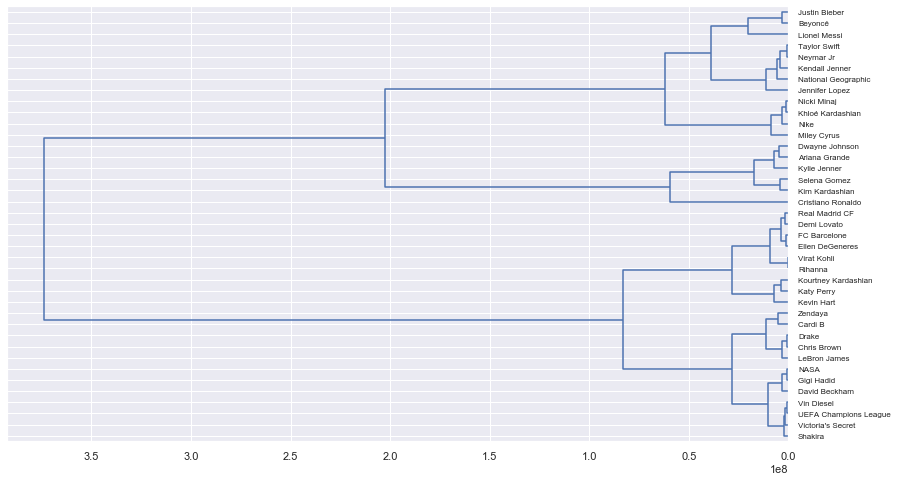

In [145]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

#Generate the links matrix
mat = linkage(instagramers,method='ward',metric='euclidean')
#affichage du dendrogramme
plt.figure( figsize=(14,8) )
dendrogram(mat,labels=instagramers.index,orientation='left',color_threshold=0)
plt.show()

No handles with labels found to put in legend.


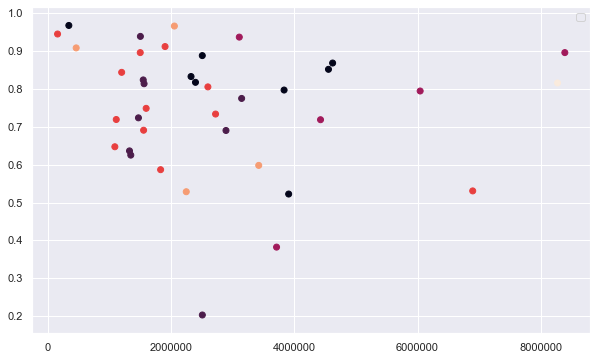

In [154]:
cah=AgglomerativeClustering(n_clusters=6,linkage='ward', compute_full_tree=True)
cah.fit(instagramers)

plt.figure(figsize=(10,6))
plt.scatter(instagramers['Post number of likes'],instagramers['Prop. of photo'],c=cah.labels_)
plt.legend()
plt.show()

## Impact of the day of the week ?

In [93]:
df['Posting date'] = df['Posting date'].apply(lambda x : x.replace(':','-'))
df['Posting date'] = df['Posting date'].apply(lambda x : x.replace('T','-'))
df['Posting date'] = df['Posting date'].apply(lambda x : x.split('-'))

df['year of posting'] = df['Posting date'].apply(lambda x : x[0]).astype(int)
df['month of posting'] = df['Posting date'].apply(lambda x : x[1]).astype(int)
df['day of posting'] = df['Posting date'].apply(lambda x : x[2]).astype(int)
df['hour of posting'] = df['Posting date'].apply(lambda x : x[3]).astype(int)

df = df.drop(columns = ['Posting date'])

date_strings = []
for i in range(df.shape[0]):
    d = df.loc[i,'day of posting']
    m = df.loc[i,'month of posting']
    y =df.loc[i,'year of posting']
    date_strings.append('{}-{}-{}'.format(d,m,y))
df['Date of Posting'] = pd.Series([pd.to_datetime(date, format='%d-%m-%Y') for date in date_strings])

df['Day of the week of Posting'] = df['Date of Posting'].dt.dayofweek

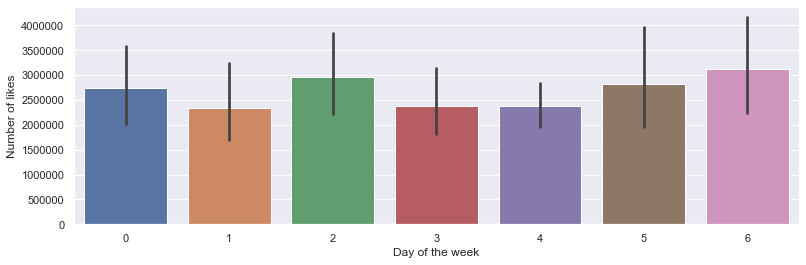

In [94]:
plt.figure(figsize=(13,4))
sns.barplot(x = 'Day of the week of Posting',y = 'Post number of likes', data = df)
plt.ylabel('Number of likes')
plt.xlabel('Day of the week')
plt.show()

## Correlation between the numbers of comments and likes

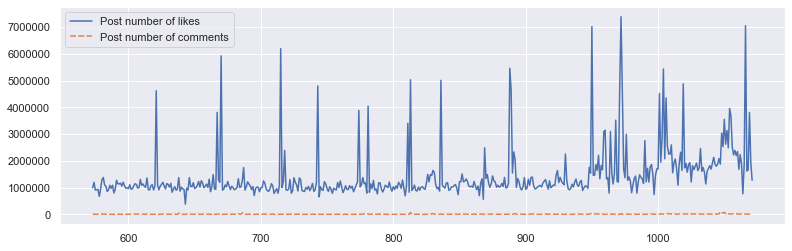

In [97]:
plt.figure(figsize=(13,4))
sns.lineplot(data=df[df['year of posting'] == 2016][["Post number of likes","Post number of comments"]])

plt.show()

# Workflow

The work flow is composed of two essential elements that make up the submission: the feature extractor and the regressor. The first allows both the preparation of initial data and the creation of new variables. The second, on the other hand, allows a supervised learning model to be trained so that the engagement rate on Instagram's post can be correctly predicted. This model is trained on a part of the base obtained from the feature extractor output, then is evaluated on the remaining part.

# Submission

## First model without NLP

To make a RAMP submission you will need to create a new directory within submissions, naming it as you wish, and a file named estimator.py within the new directory, e.g. submissions/my_new_sub/estimator.py

Within estimator.py, define a function named get_estimator that returns a scikit-learn pipeline or estimator that performs the desired feature extraction and regression.

For example, the estimator.py file below will perform the workflow detailed above

In [35]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

def processing_data(df):
    
    X = df.copy()
    
    X['Number of followings'] = X['Number of followings'].astype(int)
    X['Number of posts'] = X['Number of posts'].apply(lambda x : x.replace("publications","")).apply(lambda x : x.replace(" ","")).astype(int)
    X['Post number of likes'] = X['Post number of likes'].apply(lambda x : x.replace(" ","")).astype(int)
    X['Media Type'] = df['Media Type'].replace({'Photo':0, 'Video':1})

    X['Number of words'] = pd.Series([len(re.findall(r'\w+', line)) for line in X['Post description']])
    
    X = X[['Number of followings','Number of posts','Post number of likes','Media Type','Number of words']]
    
    return X.values

def processing_date(df):
    
    X = df.copy()
    
    X['Posting date'] = X['Posting date'].apply(lambda x : x.replace(':','-'))
    X['Posting date'] = X['Posting date'].apply(lambda x : x.replace('T','-'))
    X['Posting date'] = X['Posting date'].apply(lambda x : x.split('-'))

    X['y'] = X['Posting date'].apply(lambda x : x[0]).astype(int)
    X['m'] = X['Posting date'].apply(lambda x : x[1]).astype(int)
    X['d'] = X['Posting date'].apply(lambda x : x[2]).astype(int)
    X['h'] = X['Posting date'].apply(lambda x : x[3]).astype(int)
    
    date_strings = []
    for i in range(df.shape[0]):
        d, m, y = X.loc[i,'d'], X.loc[i,'m'], X.loc[i,'y']
        date_strings.append('{}-{}-{}'.format(d,m,y))
    X['Date of Posting'] = pd.Series([pd.to_datetime(date, format='%d-%m-%Y') for date in date_strings])
    X['day_week'] = X['Date of Posting'].dt.dayofweek
    
    x_hour,x_day,x_month,x_year = np.array([X['h']]),np.array([X['d']]),np.array([X['m']]),np.array([X['y']])
    x_day_week = np.array([X['day_week']])
    
    return np.array([x_hour, x_day, x_month, x_year, x_day_week]).T.reshape(X.shape[0],5)
    
transformer_var = FunctionTransformer(
    lambda df: processing_data(df)
)
transformer_date = FunctionTransformer(
    lambda df: processing_date(df)
)

cols = ['Nationality', 'Brand']

transformer = make_column_transformer(
    (transformer_date, ['Posting date']),
    (transformer_date, ['Number of followings','Number of posts','Post number of likes',
                        'Media Type', 'Post description']),
    ('passthrough', cols),
)

pipe = make_pipeline(
    transformer,
    RandomForestRegressor()
)
    
def get_estimator():
    return pipe